In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from pathlib import Path

In [3]:
from famews.fairness_check.utils.helper_groups import get_map_group_pid, get_map_not_group_pid
from famews.fairness_check.utils.get_pop_info import check_group_has_event
from famews.fairness_check.utils.compute_threshold_score import find_threshold_event_recall, find_threshold_precision_recall
from famews.fairness_check.metrics import get_event_recall, get_precision, get_corrected_precision
from famews.fairness_check.utils.helper_bootstrap import draw_bootstrap_sample
from famews.fairness_check.utils.stat_tests import run_mann_whitney_u
from famews.fairness_check.model_performance.helper_analyse_performance import map_predictions_group, compute_prevalence_groups

In [ ]:
from RMS.fairness_analysis.data_processing import get_mean_rf_preds, get_mean_extf_preds, get_event_bounds_resp, get_event_bounds_resp, build_patient_groups

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

PATH_SPLIT = os.get_env('PATH_SPLIT')
PATH_CHUNK = os.get_env('PATH_CHUNK')
ROOT_DIR_PRED = os.get_env('ROOT_DIR_PRED')
PATH_ENDPT_DIR = os.get_env('PATH_ENDT_DIR')
PATH_STATIC_PATIENTS = os.get_env('PATH_STATIC_PATIETNS')

# Respiratory failure

In [ ]:
from RMS.fairness_analysis.utils_resp import get_group_threshold, run_stat_test_binary, run_stat_test_multi, run_analysis

In [4]:
predictions = get_mean_rf_preds(Path(PATH_SPLIT), Path(PATH_CHUNK), Path(PATH_PRED_DIR_RESP))
event_bounds = get_event_bounds_resp(Path(PATH_ENDPT_DIR))
df_patients = build_patient_groups(PATH_STATIC_PATIENTS).loc[list(predictions.keys())]

In [7]:
bootstrap_sample_pids = draw_bootstrap_sample(
                list(predictions.keys()), sample_size=1, n_samples=100
            )

In [8]:
global_thres_08 = find_threshold_event_recall(0.8, predictions, list(predictions.keys()), event_bounds,
                                                       24, 8064, 5)
global_thres_09 = find_threshold_event_recall(0.9, predictions, list(predictions.keys()), event_bounds,
                                                       24, 8064, 5)

In [9]:
preds_array = []
labels_array = []
for pid, (pred, label) in predictions.items():
    mask_nan = np.isnan(label)
    preds_array.append(pred[~mask_nan])
    labels_array.append(label[~mask_nan])
preds_array = np.concatenate(preds_array)
labels_array = np.concatenate(labels_array)

In [10]:
global_precision_08 = get_precision(labels_array, (preds_array >= global_thres_08).astype(int))
global_precision_09 = get_precision(labels_array, (preds_array >= global_thres_09).astype(int))

In [11]:
metrics_overall = []
for it, boot_pids in enumerate(bootstrap_sample_pids):
    preds_array = []
    labels_array = []
    for pid in boot_pids:
        pred, label = predictions[pid]
        mask_nan = np.isnan(label)
        preds_array.append(pred[~mask_nan])
        labels_array.append(label[~mask_nan])
    preds_array = np.concatenate(preds_array)
    labels_array = np.concatenate(labels_array)
    precision_08 = get_precision(labels_array, (preds_array >= global_thres_08).astype(int))
    precision_09 = get_precision(labels_array, (preds_array >= global_thres_09).astype(int))
    metrics_overall.append({'precision_0.8': precision_08, 'precision_0.9': precision_09, 'group': "_",
                                 'cat': "overall", 'run': it})
metrics_overall = pd.DataFrame(metrics_overall)

In [ ]:
global_prevalence = np.sum(labels_array) / len(labels_array)

## Sex

In [14]:
group_name = 'sex'
cats = ['F', 'M']

In [15]:
df_metrics, with_stars = run_analysis(group_name, cats, 0.001/4)
df_metrics = pd.concat((df_metrics, metrics_overall))

In [ ]:
map_group_pid = get_map_group_pid(df_patients, 'sex', ['F', 'M'])
(labels_array_sex, 
 preds_array_sex,) = map_predictions_group(predictions, map_group_pid)
prev_dict, _, _ = compute_prevalence_groups(labels_array_sex)

In [16]:
with_stars

{'precision_0.8': ['F'], 'precision_0.9': ['F']}

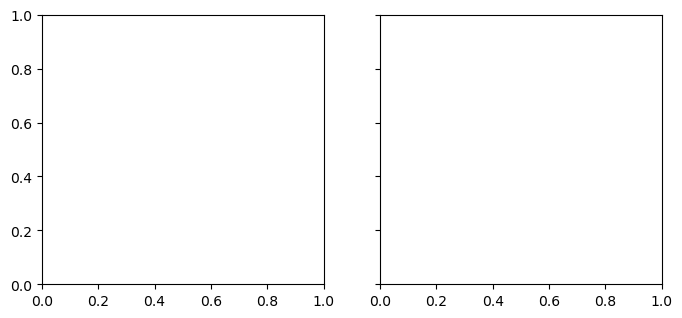

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5), sharey=True)

In [18]:
metric = 'precision_0.8'
pretty_name_metric = "Precision@ 80% Recall"
ax = axs[0]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:gray'])
ax.set_title(pretty_name_metric)
ax.set_xlabel("Alarm precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2 ], ['F      \n(n=1565)', 'M      \n(n=2834)', 'overall \n(n=4399)'])
ax.tick_params(axis="y", labelsize=8)
ax.axvline(global_precision_08, c='0.3', ls=':')
ax.set(xlim=(0, 1))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == 'F'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 0 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')

Text(0.4439786886564929, -0.25, '*')

In [19]:
metric = 'precision_0.9'
pretty_name_metric = "Precision@ 90% Recall"
ax = axs[1]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:gray'])

ax.set_title(pretty_name_metric)
ax.set_xlabel("Alarm precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2 ], ['F      \n(n=1565)', 'M      \n(n=2834)', 'overall \n(n=4399)'])
ax.tick_params(axis="y", labelsize=10)
ax.axvline(global_precision_09, c='0.3', ls=':', )
ax.set(xlim=(0, 1))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == 'F'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 0 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == 'M'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 1 - 0.25

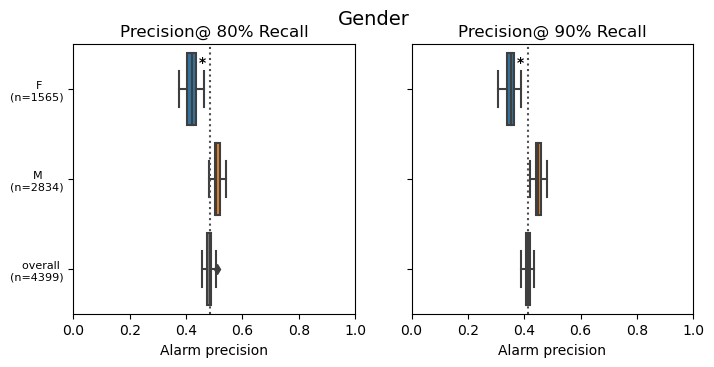

In [20]:
fig.suptitle("Gender", fontsize=14)
fig

In [ ]:
fig = plt.figure(figsize=(1,3.5))
sns.barplot(y=list(prev_dict.keys()), x=list(prev_dict.values()), orient = 'h', width=0.1, 
            palette=['tab:blue', 'tab:orange', 'tab:gray'])
plt.xlim((0, 0.4))
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], ['0', '', '0.2', '', '0.4'])
plt.axvline(global_prevalence, c='0.3', ls=':')
plt.tick_params(labelleft=False) 
plt.title("Prevalence")
plt.xlabel("Positive labels\nprevalence")
fig.suptitle(' ')
plt.show()

## Age group

In [21]:
group_name = 'age_group'
cats = ['<50', '50-65', '65-75', '75-85', '>85']

In [22]:
df_metrics, with_stars = run_analysis(group_name, cats, 0.001/(2*2*5))

In [23]:
with_stars

{'precision_0.8': ['<50', '75-85', '>85'],
 'precision_0.9': ['<50', '75-85', '>85']}

In [24]:
df_metrics = df_metrics[df_metrics['group']==group_name]
df_metrics = pd.concat((df_metrics, metrics_overall))

In [ ]:
map_group_pid = get_map_group_pid(df_patients, 'age_group', ['<50', '50-65', '65-75', '75-85', '>85'])
(labels_array_age, preds_array_age,) = map_predictions_group(predictions, map_group_pid)
prev_dict, _, _ = compute_prevalence_groups(labels_array_age)

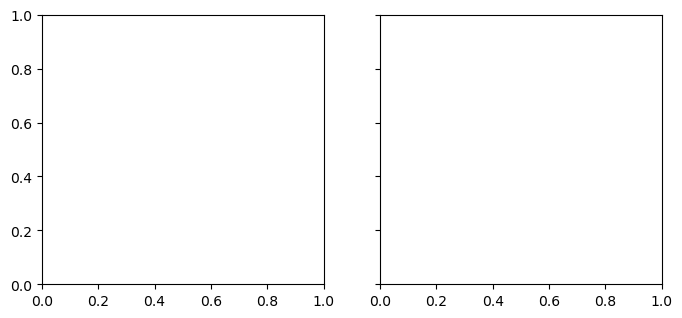

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True)

In [26]:
metric = 'precision_0.8'
pretty_name_metric = "Precision@ 80% Recall"
ax = axs[0]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:gray'])
ax.set_title(pretty_name_metric)
ax.set_xlabel("Alarm precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2, 3, 4, 5], ['<50  \n(n=467)', '50-65  \n(n=1292)', '65-75  \n(n=1335)', '75-85  \n(n=1056)', 
                                '>85  \n(n=249)', 'overall \n(n=4399)'])
ax.tick_params(axis="y", labelsize=8)
ax.axvline(global_precision_08, c='0.3', ls=':')
ax.set(xlim=(0, 1))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == '<50'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 0 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == '75-85'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 3 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == '>85'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 4 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')

Text(0.32571492175237693, 3.75, '*')

In [27]:
metric = 'precision_0.9'
pretty_name_metric = "Precision@ 90% Recall"
ax = axs[1]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:gray'])

ax.set_title(pretty_name_metric)
ax.set_xlabel("Alarm precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2, 3, 4, 5], ['<50  \n(n=467)', '50-65  \n(n=1292)', '65-75  \n(n=1335)', '75-85  \n(n=1056)', 
                                '>85  \n(n=249)', 'overall \n(n=4399)'])
ax.tick_params(axis="y", labelsize=10)
ax.axvline(global_precision_09, c='0.3', ls=':', )
ax.set(xlim=(0, 1))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == '<50'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 0 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == '75-85'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 3 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == '>85'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 4 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')

Text(0.2872419488667952, 3.75, '*')

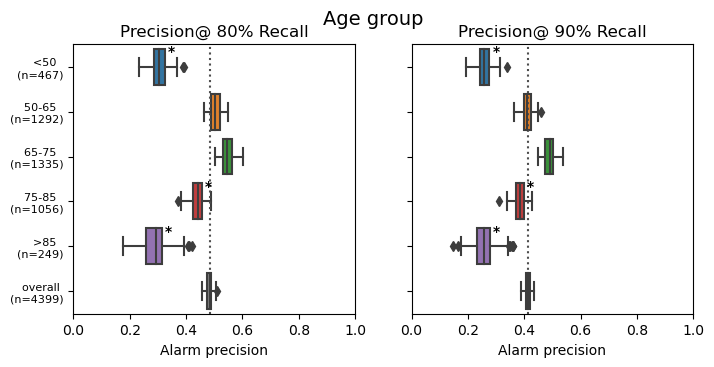

In [28]:
fig.suptitle("Age group", fontsize=14)
fig

In [ ]:
fig=plt.figure(figsize=(1,3.5))
sns.barplot(y=list(prev_dict.keys()), x=list(prev_dict.values()), orient = 'h', width=0.1,palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:gray'] )
plt.xlim((0, 0.4))
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], ['0', '', '0.2', '', '0.4'])
plt.axvline(global_prevalence, c='0.3', ls=':')
plt.tick_params(labelleft=False) 
plt.title("Prevalence")
plt.xlabel("Positive labels\nprevalence")
fig.suptitle(" ")
plt.show()

## APACHE group

In [29]:
group_name = 'APACHE_group'
cats = ['Neurological', 'Cardiovascular', 'Gastrointestinal', 'Respiratory', 'Trauma', 'Other']

In [30]:
df_metrics, with_stars = run_analysis(group_name, cats, 0.001/(2*2*6))

In [31]:
with_stars

{'precision_0.8': ['Neurological', 'Gastrointestinal', 'Trauma'],
 'precision_0.9': ['Neurological', 'Gastrointestinal', 'Trauma']}

In [32]:
df_metrics = df_metrics[df_metrics['group']==group_name]
df_metrics = pd.concat((df_metrics, metrics_overall))

In [ ]:
map_group_pid = get_map_group_pid(df_patients, 'APACHE_group', ['Neurological', 'Cardiovascular', 
                                                                     'Gastrointestinal', 'Respiratory', 'Trauma', 
                                                                     'Other'])
(labels_array_apache, preds_array_apache,) = map_predictions_group(predictions, map_group_pid)
prev_dict, _, _ = compute_prevalence_groups(labels_array_apache)

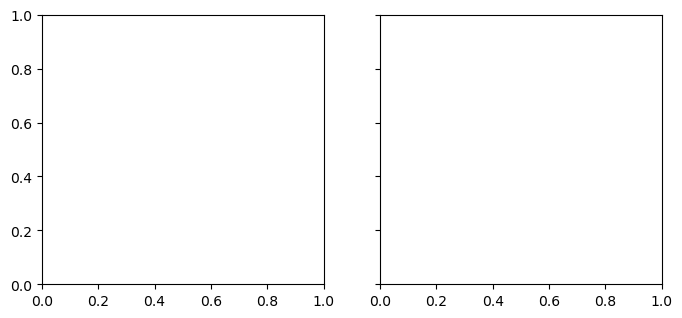

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True)

In [34]:
metric = 'precision_0.8'
pretty_name_metric = "Precision@ 80% Recall"
ax = axs[0]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:brown', 'tab:gray'])
ax.set_title(pretty_name_metric)
ax.set_xlabel("Alarm precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2, 3, 4, 5, 6],  ['Neurological\n(n=1490)', 'Cardiovascular\n(n=1307)', 'Gastrointestinal\n(n=545)', 
                                'Respiratory\n(n=332)', 'Trauma\n(n=300)', 'Other\n(n=394)', 'Overall\n(n=4399)'])
ax.tick_params(axis="y", labelsize=8)
ax.axvline(global_precision_08, c='0.3', ls=':')
ax.set(xlim=(0, 1))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == 'Neurological'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 0 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == 'Gastrointestinal'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 2 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == 'Trauma'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 4 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')

Text(0.41468488491187383, 3.75, '*')

In [35]:
metric = 'precision_0.9'
pretty_name_metric = "Precision@ 90% Recall"
ax = axs[1]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:brown', 'tab:gray'])

ax.set_title(pretty_name_metric)
ax.set_xlabel("Alarm precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2, 3, 4, 5, 6],  ['Neurological\n(n=1490)', 'Cardiovascular\n(n=1307)', 'Gastrointestinal\n(n=545)', 
                                'Respiratory\n(n=332)', 'Trauma\n(n=300)', 'Other\n(n=394)', 'Overall\n(n=4399)'])
ax.tick_params(axis="y", labelsize=10)
ax.axvline(global_precision_09, c='0.3', ls=':', )
ax.set(xlim=(0, 1))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == 'Neurological'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 0 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == 'Gastrointestinal'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 2 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == 'Trauma'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 4 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')

Text(0.3643443363590098, 3.75, '*')

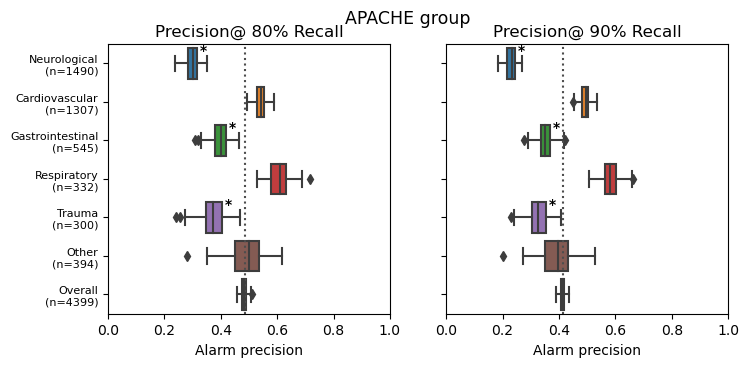

In [36]:
fig.suptitle("APACHE group", fontsize=12.5)
fig

In [ ]:
fig=plt.figure(figsize=(1,3.5))
sns.barplot(y=list(prev_dict.keys()), x=list(prev_dict.values()), orient = 'h', width=0.1,  
            palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:gray'])
plt.xlim((0, 0.4))
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], ['0', '', '0.2', '', '0.4'])
plt.axvline(global_prevalence, c='0.3', ls=':')
plt.tick_params(labelleft=False) 
plt.title('Prevalence')
plt.xlabel("Positive labels\nprevalence")
fig.suptitle(" ")
plt.show()

# Extubation failure

In [ ]:
from RMS.fairness_analysis.utils_extb import get_group_threshold, run_stat_test_binary, run_stat_test_multi, run_analysis

In [37]:
predictions = get_mean_extf_preds(Path(PATH_SPLIT), Path(PATH_CHUNK), Path(ROOT_DIR_PRED))
event_bounds = get_event_bounds_extf(predictions)
df_patients = build_patient_groups(Path(PATH_STATIC_PATIENTS)).loc[list(predictions.keys())]

In [40]:
bootstrap_sample_pids = draw_bootstrap_sample(
                list(predictions.keys()), sample_size=1, n_samples=1000
            )

In [41]:
preds_array = []
labels_array = []
for pid, (pred, label) in predictions.items():
    mask_nan = np.isnan(label)
    preds_array.append(pred[~mask_nan])
    labels_array.append(label[~mask_nan])
preds_array = np.concatenate(preds_array)
labels_array = np.concatenate(labels_array)

In [42]:
global_thres_08 = find_threshold_precision_recall(0.8, 'recall', labels_array, preds_array)
global_thres_02 = find_threshold_precision_recall(0.2, 'recall', labels_array, preds_array)

In [43]:
global_precision_08 = get_precision(labels_array, (preds_array >= global_thres_08).astype(int))
global_precision_02 = get_precision(labels_array, (preds_array >= global_thres_02).astype(int))

In [44]:
metrics_overall = []
for it, boot_pids in enumerate(bootstrap_sample_pids[:100]):
    preds_array = []
    labels_array = []
    for pid in boot_pids:
        pred, label = predictions[pid]
        mask_nan = np.isnan(label)
        preds_array.append(pred[~mask_nan])
        labels_array.append(label[~mask_nan])
    preds_array = np.concatenate(preds_array)
    labels_array = np.concatenate(labels_array)
    precision_08 = get_precision(labels_array, (preds_array >= global_thres_08).astype(int))
    precision_02 = get_precision(labels_array, (preds_array >= global_thres_02).astype(int))
    metrics_overall.append({'precision_0.8': precision_08, 'precision_0.2': precision_02, 'group': "_",
                                 'cat': "overall", 'run': it})
metrics_overall = pd.DataFrame(metrics_overall)

In [ ]:
global_prevalence = np.sum(labels_array) / len(labels_array)

## Sex

In [47]:
group_name = 'sex'
cats = ['F', 'M']

In [48]:
df_metrics, with_stars = run_analysis(group_name, cats, 0.001/4)
df_metrics = pd.concat((df_metrics, metrics_overall))

In [49]:
with_stars

{'precision_0.8': ['F'], 'precision_0.2': ['F']}

In [ ]:
map_group_pid = get_map_group_pid(df_patients, 'sex', ['F', 'M'])
(labels_array_sex, preds_array_sex,) = map_predictions_group(predictions, map_group_pid)
prev_dict, _, _ = compute_prevalence_groups(labels_array_sex)

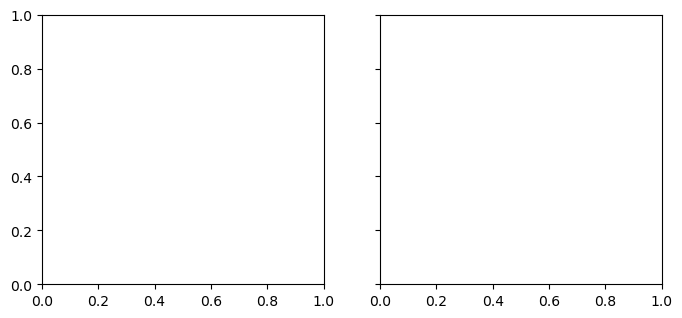

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5), sharey=True)

In [51]:
metric = 'precision_0.8'
pretty_name_metric = "Precision@ 80% Recall"
ax = axs[0]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:gray'])
ax.set_title(pretty_name_metric)
ax.set_xlabel("Precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2 ], ['F      \n(n=1565)', 'M      \n(n=2834)', 'overall \n(n=4399)'])
ax.tick_params(axis="y", labelsize=8)
ax.axvline(global_precision_08, c='0.3', ls=':')
ax.set(xlim=(-0.05, 1.05))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == 'F'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 0 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')

Text(0.2687088129830032, -0.25, '*')

In [52]:
metric = 'precision_0.2'
pretty_name_metric = "Precision@ 20% Recall"
ax = axs[1]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:gray'])

ax.set_title(pretty_name_metric)
ax.set_xlabel("Precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2 ], ['F      \n(n=1565)', 'M      \n(n=2834)', 'overall \n(n=4399)'])
ax.tick_params(axis="y", labelsize=10)
ax.axvline(global_precision_02, c='0.3', ls=':', )
ax.set(xlim=(-0.05, 1.05))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == 'F'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 0 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == 'M'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 1 - 0.25

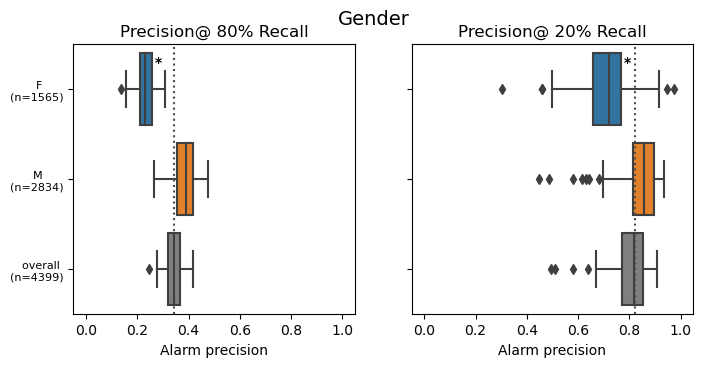

In [53]:
fig.suptitle("Gender", fontsize=14)
fig

In [ ]:
fig=plt.figure(figsize=(1,3.5))
sns.barplot(y=list(prev_dict.keys()), x=list(prev_dict.values()), orient = 'h', width=0.1, palette=['tab:blue', 'tab:orange', 'tab:gray'])
plt.xlim((0, 0.3))
plt.xticks([0, 0.1, 0.2, 0.3], ['0', '', '0.2', ''])
plt.axvline(global_prevalence, c='0.3', ls=':')
plt.tick_params(labelleft=False) 
plt.title("Prevalence")
plt.xlabel("Positive labels\nprevalence")
fig.suptitle(" ")
plt.show()

## Age group

In [54]:
group_name = 'age_group'
cats = ['<50', '50-65', '65-75', '75-85', '>85']

In [55]:
df_metrics, with_stars = run_analysis(group_name, cats, 0.001/(2*2*5))

In [56]:
with_stars

{'precision_0.8': ['75-85'], 'precision_0.2': ['<50', '75-85']}

In [57]:
df_metrics = df_metrics[df_metrics['group']==group_name]
df_metrics = pd.concat((df_metrics, metrics_overall))

In [ ]:
map_group_pid = get_map_group_pid(df_patients, 'age_group', ['<50', '50-65', '65-75', '75-85', '>85'])
(labels_array_age, preds_array_age,) = map_predictions_group(predictions, map_group_pid)
prev_dict, _, _ = compute_prevalence_groups(labels_array_age)

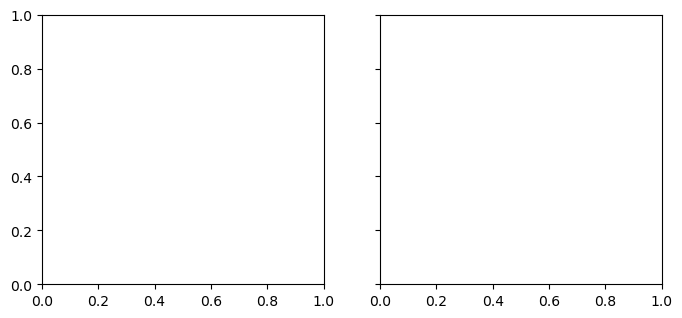

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True)

In [59]:
metric = 'precision_0.8'
pretty_name_metric = "Precision@ 80% Recall"
ax = axs[0]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:gray'])
ax.set_title(pretty_name_metric)
ax.set_xlabel("Precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2, 3, 4, 5], ['<50  \n(n=467)', '50-65  \n(n=1292)', '65-75  \n(n=1335)', '75-85  \n(n=1056)', 
                                '>85  \n(n=249)', 'overall \n(n=4399)'])
ax.tick_params(axis="y", labelsize=8)
ax.axvline(global_precision_08, c='0.3', ls=':')
ax.set(xlim=(-0.05, 1.05))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == '75-85'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 3 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')

Text(0.16640379111693868, 2.75, '*')

In [60]:
metric = 'precision_0.2'
pretty_name_metric = "Precision@ 20% Recall"
ax = axs[1]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:gray'])

ax.set_title(pretty_name_metric)
ax.set_xlabel("Precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2, 3, 4, 5], ['<50  \n(n=467)', '50-65  \n(n=1292)', '65-75  \n(n=1335)', '75-85  \n(n=1056)', 
                                '>85  \n(n=249)', 'overall \n(n=4399)'])
ax.tick_params(axis="y", labelsize=10)
ax.axvline(global_precision_02, c='0.3', ls=':', )
ax.set(xlim=(-0.05, 1.05))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == '<50'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 0 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == '75-85'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 3 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')

Text(0.5338344683080147, 2.75, '*')

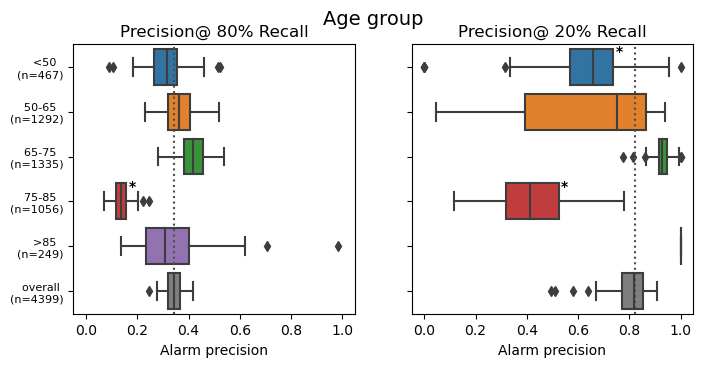

In [61]:
fig.suptitle("Age group", fontsize=14)
fig

In [ ]:
fig=plt.figure(figsize=(1,3.5))
sns.barplot(y=list(prev_dict.keys()), x=list(prev_dict.values()), orient = 'h', width=0.1, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:gray'])
plt.xlim((0, 0.3))
plt.xticks([0, 0.1, 0.2, 0.3], ['0', '', '0.2', '', ])
plt.axvline(global_prevalence, c='0.3', ls=':')
plt.tick_params(labelleft=False) 
plt.title("Prevalence")
fig.suptitle(" ")
plt.xlabel("Positive labels\nprevalence")
plt.show()

## APACHE group

In [69]:
group_name = 'APACHE_group'
cats = ['Neurological', 'Cardiovascular', 'Gastrointestinal', 'Respiratory', 'Trauma', 'Other']

In [70]:
df_metrics, with_stars = run_analysis(group_name, cats, 0.001/(2*2*6))

/cluster/work/grlab/projects/projects2022-icu-biases/projects2023-phrt-ml/phrt_ml/phrt_ml/fairness_check/metrics.py:85: UserWarning: No positive class found in y_pred, precision is set to zero.
  warnings.warn(
/cluster/work/grlab/projects/projects2022-icu-biases/projects2023-phrt-ml/phrt_ml/phrt_ml/fairness_check/metrics.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return tp / (tp + fp)
/cluster/work/grlab/projects/projects2022-icu-biases/projects2023-phrt-ml/phrt_ml/phrt_ml/fairness_check/metrics.py:85: UserWarning: No positive class found in y_pred, precision is set to zero.
  warnings.warn(
/cluster/work/grlab/projects/projects2022-icu-biases/projects2023-phrt-ml/phrt_ml/phrt_ml/fairness_check/metrics.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return tp / (tp + fp)
/cluster/work/grlab/projects/projects2022-icu-biases/projects2023-phrt-ml/phrt_ml/phrt_ml/fairness_check/metrics.py:85: UserWarning: No positive class found in y_pred, prec

In [71]:
with_stars

{'precision_0.8': ['Cardiovascular', 'Trauma', 'Other'],
 'precision_0.2': ['Gastrointestinal', 'Trauma', 'Other']}

In [72]:
df_metrics = df_metrics[df_metrics['group']==group_name]
df_metrics = pd.concat((df_metrics, metrics_overall))

In [ ]:
map_group_pid = get_map_group_pid(df_patients, 'APACHE_group', ['Neurological', 'Cardiovascular', 
                                                                     'Gastrointestinal', 'Respiratory', 'Trauma', 
                                                                     'Other'])
(labels_array_apache, preds_array_apache,) = map_predictions_group(predictions, map_group_pid)
prev_dict, _, _ = compute_prevalence_groups(labels_array_apache)

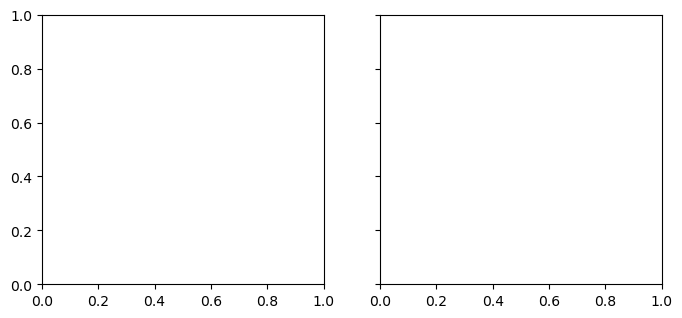

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True)

In [74]:
metric = 'precision_0.8'
pretty_name_metric = "Precision@ 80% Recall"
ax = axs[0]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:brown', 'tab:gray'])
ax.set_title(pretty_name_metric)
ax.set_xlabel("Precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2, 3, 4, 5, 6],  ['Neurological\n(n=1490)', 'Cardiovascular\n(n=1307)', 'Gastrointestinal\n(n=545)', 
                                'Respiratory\n(n=332)', 'Trauma\n(n=300)', 'Other\n(n=394)', 'Overall\n(n=4399)'])
ax.tick_params(axis="y", labelsize=8)
ax.axvline(global_precision_08, c='0.3', ls=':')
ax.set(xlim=(-0.05, 1.05))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == 'Cardiovascular'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 1 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == 'Other'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 5 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == 'Trauma'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 4 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')

Text(0.26643801786001897, 3.75, '*')

In [75]:
metric = 'precision_0.2'
pretty_name_metric = "Precision@ 20% Recall"
ax = axs[1]
sns.boxplot(data=df_metrics, x=metric, y='cat', ax=ax, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:brown', 'tab:gray'])

ax.set_title(pretty_name_metric)
ax.set_xlabel("Precision")
ax.set_ylabel("")
ax.set_yticks([0, 1, 2, 3, 4, 5, 6],  ['Neurological\n(n=1490)', 'Cardiovascular\n(n=1307)', 'Gastrointestinal\n(n=545)', 
                                'Respiratory\n(n=332)', 'Trauma\n(n=300)', 'Other\n(n=394)', 'Overall\n(n=4399)'])
ax.tick_params(axis="y", labelsize=10)
ax.axvline(global_precision_02, c='0.3', ls=':', )
ax.set(xlim=(-0.05, 1.05))
int_ticks = ax.get_xticks()[1] - ax.get_xticks()[0]
x_place = df_metrics[df_metrics['cat'] == 'Other'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 5 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == 'Gastrointestinal'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 2 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')
x_place = df_metrics[df_metrics['cat'] == 'Trauma'][metric].quantile(0.75) + int_ticks * 0.05
y_place = 4 - 0.25
ax.text(x_place, y_place, "*", fontweight="extra bold", c='k')

Text(0.642715410107705, 3.75, '*')

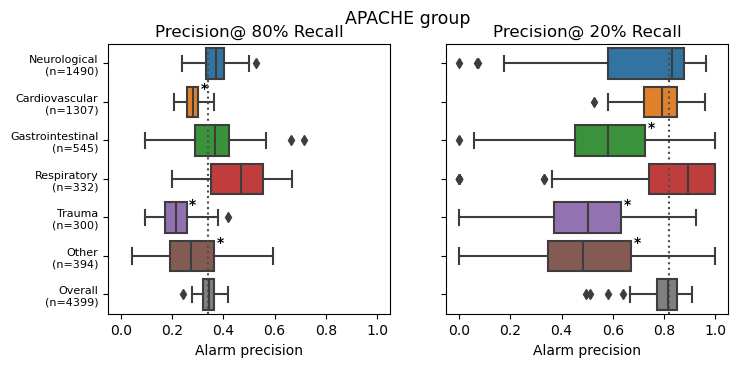

In [76]:
fig.suptitle("APACHE group", fontsize=12.5)
fig

In [ ]:
fig=plt.figure(figsize=(1,3.5))
sns.barplot(y=list(prev_dict.keys()), x=list(prev_dict.values()), orient = 'h', width=0.1, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                                                'tab:purple', 'tab:brown', 'tab:gray'])
plt.xlim((0, 0.3))
plt.xticks([0, 0.1, 0.2, 0.3], ['0', '', '0.2', ''])
plt.axvline(global_prevalence, c='0.3', ls=':')
plt.tick_params(labelleft=False) 
plt.title('Prevalence')
plt.xlabel("Positive labels\nprevalence")
fig.suptitle(" ")
plt.show()